In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from ase.build import mx2

import abtem
abtem.config.set({'local_diagnostics.progress_bar': False});

# Scan and detect

Scanning imaging modes such as STEM works by rastering an electron probe across a sample pixel by pixel and recording the scattering signal for each position. To simulate this, we perform a multislice simulation for every probe position.

## Scanned multislice

We import an atomic model of graphene with a single silicon dopant atom.

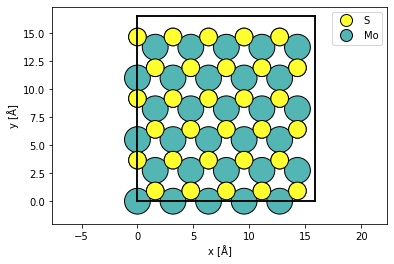

In [2]:
atoms = abtem.orthogonalize_cell(mx2(vacuum=2)) * (5, 3, 1)

abtem.show_atoms(atoms, legend=True);

Next, we create a `Potential` with a sampling of $0.05 \ \mathrm{Å}$ and a slice thickness of $1 \ \mathrm{Å}$. A `Probe` with an energy of $80 \ \mathrm{keV}$, a convergence semiangle of $30 \ \mathrm{mrad}$.

In [3]:
potential = abtem.Potential(atoms, sampling=.05, slice_thickness=1)

probe = abtem.Probe(energy=80e3, semiangle_cutoff=30, taper=2)

`abTEM` implements three scan types:

* `GridScan`: Uniformly spaced axis-aligned 2d grid of probe positions.
* `LineScan`: Uniformly spaced probe positions along a line (of arbitrary direction).
* `CustomScan`: Define the probe positions as an arbitrary $N \times 2$ array of numbers.

The `GridScan` is most commonly used, however, STEM simulations can be expensive, and the `LineScan` may be a way to save some computations. 

Below we create a `LineScan` across the potential by giving the `start` and `end` point as a fraction of the `potential.extent`. We specify 100 grid points along the scan. We set `endpoint=False`, as the potential is periodic the specified `start` and `end` is equivalent. Setting `endpoint=False` whjen scanning over a periodic unit will allow us to tile the resulting measurement, as shown later. 

The scan types may be visualized by adding them to a `matplotlib` plot. 

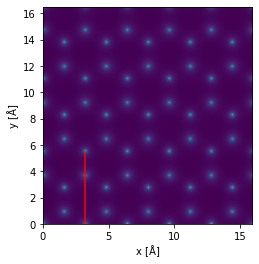

In [4]:
line_scan = abtem.LineScan(start = [potential.extent[0] / 5, 0], 
                     end =   [potential.extent[0] / 5, potential.extent[1] / 3], 
                     gpts = 100,
                     endpoint = False)

fig, ax = potential.show()
line_scan.add_to_plot(ax)

Calling `multislice` with the `LineScan` and `Potential` will result in the exit wave functions for every probe position along the scan. 

In [5]:
exit_waves_line = probe.multislice(potential, scan=line_scan)

exit_waves_line

--------------------------------------------------

type           label    coordinates
-------------  -------  -------------------
ScanAxis       x [Å]    0.00 0.06 ... 5.45
RealSpaceAxis  x [Å]    0.00 0.05 ... 15.85
RealSpaceAxis  y [Å]    0.00 0.05 ... 16.47

        bytes      shape            count     type
------  ---------  ---------------  --------  -------------
array   80.31 MiB  (100, 318, 331)  5 tasks   complex64
chunks  80.31 MiB  (100, 318, 331)  1 chunks  numpy.ndarray

## Applying detectors
In experiments, the exit wave functions are measured using detectors, correspondingly `abTEM` implements several detector types. For now, we shall focus on the `AnnularDetector`, which depending on the choice of integration region can represent the detector used in bright-field, medium- or high-angle annular dark-field microscopy, abbreviated BF, MAADF and HAADF, respectively.

The integration region is given by an inner and outer radius in $mrad$. Below we create a detector for BF, MAADF and HAADF.

In [6]:
bright = abtem.AnnularDetector(inner = 0, outer = 30)
maadf = abtem.AnnularDetector(inner = 50, outer = 120)
haadf = abtem.AnnularDetector(inner = 90, outer = 200)

print(f'Maximum simulated scattering angle: {min(exit_waves_line.cutoff_angles):.1f} mrad')

Maximum simulated scattering angle: 278.0 mrad


We note that the maximum simulated angle ($274.4 \ \mathrm{mrad}$) is greater than the maximum detected angle ($200 \ \mathrm{mrad}$). Don't worry, an error if this is not true.

The detectors can be applied by using `detect`. In this case, the exit wave functions are converted to `LineProfiles`. 

In [7]:
haadf.detect(exit_waves_line)

-------------------------------------------------------------

type           label    coordinates
-------------  -------  ------------------
RealSpaceAxis  r [Å]    0.00 0.06 ... 5.45

        bytes    shape    count     type
------  -------  -------  --------  -------------
array   400 B    (100,)   7 tasks   float32
chunks  400 B    (100,)   1 chunks  numpy.ndarray

Scanning and detecting may be combined when using `scan`, producing a list of `LineProfile` with an entry corresponding to each detector.

In [8]:
all_detectors = [bright, maadf, haadf]

measurements = probe.scan(potential, detectors=all_detectors, scan=line_scan)

We show the `LineProfiles` below.

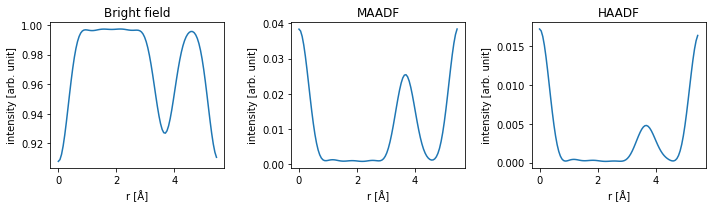

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))
measurements[0].show(ax=ax1, title='Bright field')
measurements[1].show(ax=ax2, title='MAADF');
measurements[2].show(ax=ax3, title='HAADF');

fig.tight_layout()

The `Probe` is normalized to integrate to 1 in Fourier space. We can conclude that there is almost no scattering in the hexagon centers, while 10 % of the electrons scatter outside the bright-field disk on the atoms.

```{warning}
The simulations above did not include phonon scattering which is important 
```

## STEM simulations

We perform STEM simulations using a `GridScan` much the same as we did with the `LineScan` above. We define a scan across a periodic unit of the potential using fractional coordinates with the alternate initializer `from_fractional_coordinates`. The probe step size (or `sampling`) is set to the Nyquist frequency of the probe contrast transfer function.

In [10]:
sampling = probe.ctf.nyquist_sampling
print(f'Nyquist sampling: {sampling}')

Nyquist sampling: 0.34797633804078043


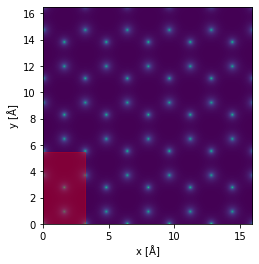

In [11]:
grid_scan = abtem.GridScan.from_fractional_coordinates(potential, 
                                                       start = [0, 0], 
                                                       end = [1 / 5, 1 / 3],
                                                       sampling = sampling)

fig, ax = potential.show()
grid_scan.add_to_plot(ax)

We create the task graph for the STEM simulation resulting in a list of `Images`. 

In [12]:
measurements = probe.scan(potential, 
                          scan=grid_scan, 
                          detectors=all_detectors)

It is convenient to stack the measurements into a single `Images`, now they can be saved as a single file.

In [13]:
measurements = abtem.stack(measurements, ['BF', 'MAADF', 'HAADF'])

We write the `Images` to disk directly, this will trigger the computations to run.

In [14]:
measurements.to_zarr('mos2_stem_measurements.zarr')

We show the resulting `Images` below.

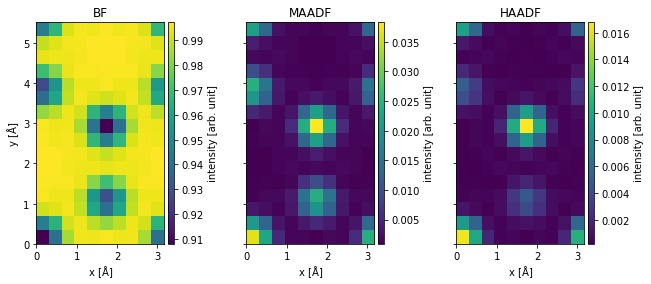

In [15]:
imported_images = abtem.from_zarr('mos2_stem_measurements.zarr')

imported_images.show(explode=True, 
                     cbar=True, 
                     image_grid_kwargs={'axes_pad': 1}, 
                     figsize=(10, 5));

## Post-processing STEM measurements

STEM multislice simulations usually requires some post-processing. We apply the mosot common post-processing steps below.

We saved a lot of computations by scanning at the Nyquist frequency, however, the result is quite pixelated. To fix this we interpolate the images to a sampling of $~ 0.1 \ \mathrm{Å / pixel}$. `abTEM`s default interpolation algorithm is Fourier space padding, however, spline interpolation is also available, which may be more appropriate if the image in non-periodic.

In [16]:
interpolated_measurement = measurements.interpolate(sampling=.1)

A finite (Gaussian-shaped) source will result in a Gaussian blurring of the image. Vibrations and other instabilities may further contribute to the blurring.

```{seealso}
Our introduction to partial coherence goes into greater depth on partial coherence in multislice simulations with `Probe` wave functions. 
```

We apply a Gaussian blur with a standard deviation of $0.3 \ \mathrm{Å}$ (corresponding to a source of approximately that size).

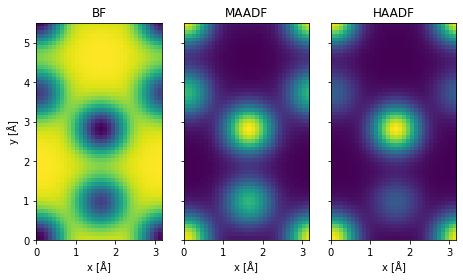

In [17]:
blurred_measurement = interpolated_measurement.gaussian_filter(.3)

blurred_measurement.show(explode=True, figsize=(12,4));

The image above corresponds to the limit of infinite electron dose. We can get a random sample with finite dose by drawing a random number from a Poisson distribution in every pixel. The Poisson distribution has mean of

$$
    \lambda = \mathrm{area \ per \ pixel} \times \mathrm{dose \ per \ area} \times \mathrm{intensity} \quad ,
$$

where it is assumed that intensity of the Fourier space `Probe` is normalized to integrate to 1.

Before applying the noise, we tile the images to get better statistics.

In [18]:
tiled_measurement = blurred_measurement.tile((7, 4))

We apply Poisson noise corresponding a dose per area of $5\times 10^4 \ e^- / \mathrm{Å}$.

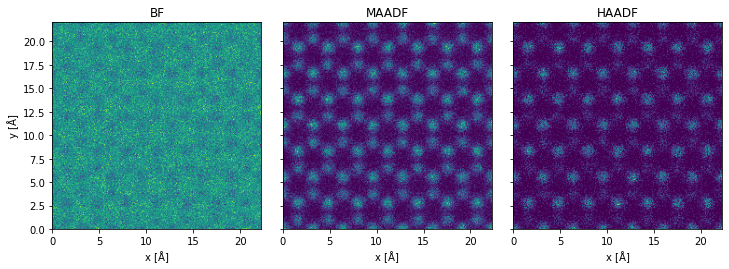

In [19]:
noisy_measurement = tiled_measurement.poisson_noise(dose_per_area=5e4)

noisy_measurement.show(explode=True, figsize=(12,4));

## Detectors

In the preceding, we introduced the `AnnularDetector`, here is the rest of the available detectors:  

* `AnnularDetector`: Integrates diffraction patterns between two scattering angles. Used for BF, MAADF and HAADF.
* `FlexibleAnnularDetector`: Used for BF, MAADF and HAADF.
* `SegmentedDetector`: Used for differential phase constrast STEM (DPC-STEM).
* `PixelatedDetector`: Used for 4D-STEM.
* `WavesDetector`: Primarily for internal use.


### `FlexibleAnnularDetector`

With the `FlexibleAnnularDetector` we can choose the integration limits after running the simulation by radially binning the diffraction patterns. This binning is allows for a far more compressed representation than saving the full diffraction patterns.

Here, we create a detector with a spacing between detector bins of $10 \ \mathrm{mrad}$.

In [20]:
flexible_detector = abtem.FlexibleAnnularDetector(step_size=10)

We run the scanned multislice simulations.

In [21]:
flexible_measurement = probe.scan(potential, scan=grid_scan, detectors=flexible_detector)

The result is a `PolarMeasurements` where the measurement values are binned on a uniform polar grid, where two base axes represents the radial and azimuthal directions.

In this, there is only a single azimuthal coordinate.

In [22]:
flexible_measurement

------------------------------------------------------------------

type        label                             coordinates
----------  --------------------------------  ---------------------
ScanAxis    x [Å]                             0.00 0.32 ... 2.86
ScanAxis    y [Å]                             0.00 0.34 ... 5.16
LinearAxis  Radial scattering angle [mrad]    0.00 10.00 ... 260.00
LinearAxis  Azimuthal scattering angle [rad]  0.00

        bytes      shape            count     type
------  ---------  ---------------  --------  -------------
array   16.88 kiB  (10, 16, 27, 1)  13 tasks  float32
chunks  15.82 kiB  (10, 15, 27, 1)  2 chunks  numpy.ndarray

We can reproduce the same BF, MAADF and HAADF measurements as above by integrating the `PolarMeasurements`.

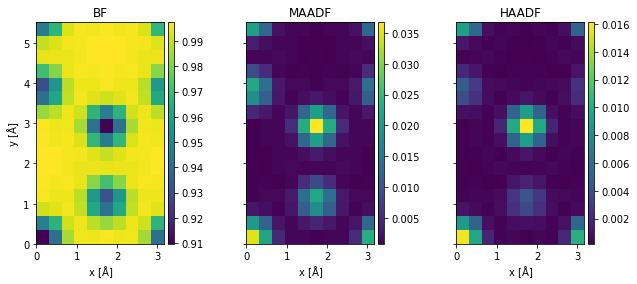

In [23]:
stacked = abtem.stack([
    flexible_measurement.integrate_radial(0, 30),
    flexible_measurement.integrate_radial(50, 120),
    flexible_measurement.integrate_radial(90, 200),
],
    ('BF', 'MAADF', 'HAADF')
)

stacked.show(explode=True, 
             cbar=True, 
             image_grid_kwargs={'axes_pad': 1}, 
             figsize=(10, 5));

### `SegmentedDetector`

The `SegmentedDetector` covers an annular region and is partitioned into several detector regions divided into radial and azimuthal segments. 

Below we define a `SegmentedDetector` covering an annular region between $40$ and $80 \ \mathrm{mrad}$. It is divided 
into $2$ radial regions, each of which are divided into $4$ azimuthal regions. The detector regions are rotated by $45 \ \mathrm{deg.}$ with respect to the principal cartesian axes.

In [24]:
segmented_detector = abtem.SegmentedDetector(inner = 40, 
                                       outer = 80, 
                                       nbins_radial = 2, 
                                       nbins_azimuthal = 4, 
                                       rotation = np.pi / 4)

We illustrate the detector regions below using a polar plot.

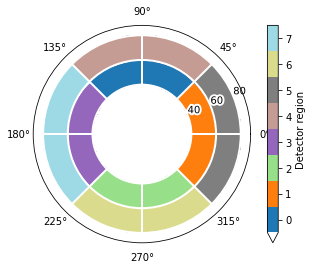

In [25]:
segmented_detector.show(radial_ticks=[40, 60, 80]);

We run the scanned multislice simulations. The resulting `PolarMeasurement` is 4d, the first two (ensemble) axes represents the scan directions and the 

In [26]:
segmented_measurement = probe.scan(potential, scan=grid_scan, detectors=segmented_detector)

segmented_measurement.compute()

------------------------------------------------------------------

type        label                             coordinates
----------  --------------------------------  ------------------
ScanAxis    x [Å]                             0.00 0.32 ... 2.86
ScanAxis    y [Å]                             0.00 0.34 ... 5.16
LinearAxis  Radial scattering angle [mrad]    40.00 60.00
LinearAxis  Azimuthal scattering angle [rad]  0.79 2.36 ... 5.50

        bytes     shape           count     type
------  --------  --------------  --------  -------------
array   5.00 kiB  (10, 16, 2, 4)  -         float32
chunks  -         -               - chunks  numpy.ndarray

We show the detected intensities for scan position `(1, 1)` on a polar plot. This scan position offset from the atom at $(x,y) = (0,0)$ at an angle of $~ 45 \ \mathrm{deg.}$, hence the electric field attracts more electrons towards detector regions at $~ 225 \ \mathrm{deg.}$

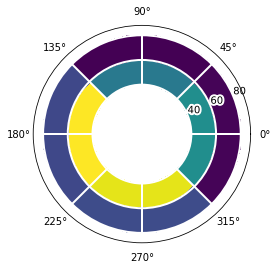

In [27]:
segmented_measurement[1, 1].show(radial_ticks=[40, 60, 80]);

Below we calculate the differential signals in the $x$ and $y$. The differential signal in the $x$-direction is calculated as the intensity difference between detector regions 1 and 3, in the $y$-direction is obtained by subtracting the intensity difference between detector regions 0 and 2.

In [28]:
differential = segmented_measurement.differentials(direction_1_plus = (1,),
                                                   direction_1_minus = (3,),
                                                   direction_2_plus = (0,),
                                                   direction_2_minus = (2,),
                                                   return_complex = True
                                                   )

The differential signal is returned as a complex `Images`, where the real and imaginary parts correspond to the $x$- and $y$-direction, respectively.

To show the results, we first interpolate and tile. The different representations of the complex parts are stacked to show an exploded plot.

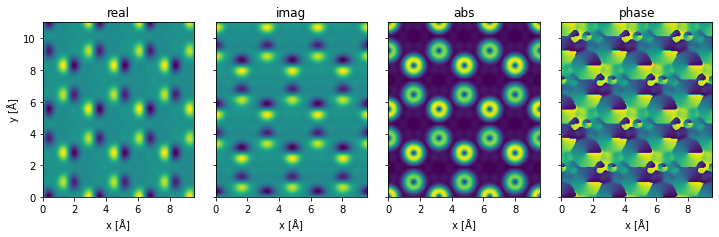

In [29]:
interpolated_differential = differential.interpolate(.05).tile((3, 2))

abtem.stack([
        interpolated_differential.real(),
        interpolated_differential.imag(),
        interpolated_differential.abs(),
        interpolated_differential.phase()
    ],
    ('real', 'imag', 'abs', 'phase')
).show(explode=True, figsize=(12, 4));

We can also display complex `Images` using [domain coloring](https://en.wikipedia.org/wiki/Domain_coloring). The phase is represented as a hue and the brightness is related to the absolute value.

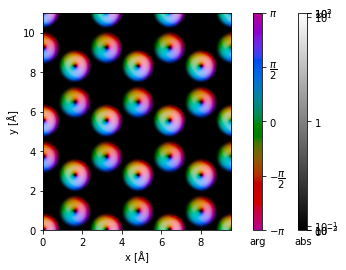

In [30]:
domain_coloring_kwargs = {'saturation_adjustment': 3,
                          'abs_scaling': lambda x: x ** 1.7 / (1 + x ** 1.7) 
                          }

(interpolated_differential * 1e3).show(domain_coloring_kwargs=domain_coloring_kwargs, cbar=True);

### `PixelatedDetector`

The `PixelatedDetector` records the diffraction patterns for every probe position. Hence, a 2D scan with this detector results in a four-dimensional dataset. The 4D datasets can be used to reconstruct the results of all the other detector geometries, hence the only downside of this detector is the high memory or disk space requirements of storing the data.

In [31]:
pixelated_detector = abtem.PixelatedDetector(max_angle = 100)

In [32]:
pixelated_measurements = probe.scan(potential, scan=grid_scan, detectors=pixelated_detector)

pixelated_measurements.compute()

--------------------------------------------------------------------

type              label       coordinates
----------------  ----------  ------------------
ScanAxis          x [Å]       0.00 0.32 ... 2.86
ScanAxis          y [Å]       0.00 0.34 ... 5.16
FourierSpaceAxis  kx [1 / Å]  0.00 0.06 ... 4.97
FourierSpaceAxis  ky [1 / Å]  0.00 0.06 ... 4.84

        bytes     shape             count     type
------  --------  ----------------  --------  -------------
array   3.96 MiB  (10, 16, 80, 81)  -         float32
chunks  -         -                 - chunks  numpy.ndarray

We show the detected intensities for scan position `(1, 1)` on up to $80 \ \mathrm{mrad}$. Since the diffraction pattern is dominated by the direct disk, we show it in three different ways: with no modifications, on a power scale with a small power of $0.1$ and blocking the direct disk.

We can make the same observation, as we did for the `SegmentedDetector`; the electrons are attracted in the direction of the atomic potential.

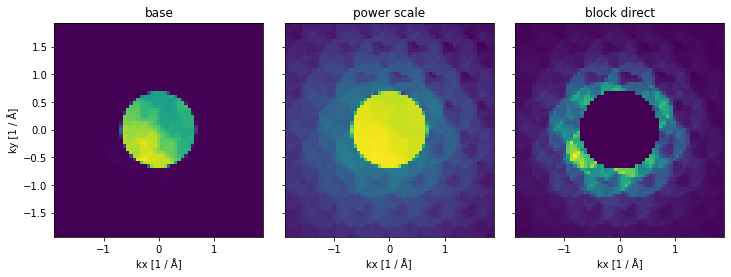

In [33]:
cropped_diffraction_pattern = pixelated_measurements[1, 1].crop(max_angle=80)

abtem.stack([
    cropped_diffraction_pattern,
    cropped_diffraction_pattern ** .1,
    cropped_diffraction_pattern.block_direct()],
    ('base', 'power scale', 'block direct')
).show(explode=True, figsize=(12, 4));

In [34]:
center_of_mass = pixelated_measurements.center_of_mass()

(<Figure size 432x288 with 4 Axes>, <Axes:xlabel='x [Å]', ylabel='y [Å]'>)

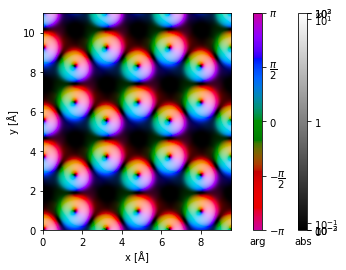

In [35]:
interpolated_center_of_mass = center_of_mass.interpolate(.05).tile((3, 2))

domain_coloring_kwargs = {'saturation_adjustment': 4,
                          'abs_scaling': lambda x: x ** 1.5 / (1 + x ** 1.5) 
                          }

interpolated_center_of_mass.show(domain_coloring_kwargs=domain_coloring_kwargs, cbar=True)

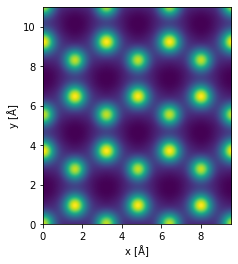

In [36]:
integrated_gradient = center_of_mass.integrate_gradient()

interpolated_integrated_gradient = integrated_gradient.interpolate(.05).tile((3, 2))

interpolated_integrated_gradient.show();